# Coursera Capstone Project - The Battle of Neighborhoods 

## Problem Description and Background

#### This project is aimed to help an entrepreneur in setting up a new cafe in the York, Canada.  
When it comes to deciding a neighborhood to position a new cafe, the important aspect to consider is who is the target audience and which neighborhood would provide the maximum accessibility to that audience. 

Let's say that the new cafe is a health cafe serving high protein, low calorie drinks and snacks. The best neighborhood for such a cafe would be one with maximum number of health and training centres, gyms and other workout places and minimum number of other cafes.

It is not feasible to suggest a single neighborhood to the entrepreneur since we are not aware of her budget and the property prices in that specific neighborhood. So, instead we will create clusters of neighboorhoods based on  their similarity in terms of number of cafes, types of restaurants, number of workout studios, etc. This will give entrepreneur the flexibility to select a neighborhood based on her requirements.


In [1]:
#!pip install geocoder

In [32]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

## Data Gathering and Preparation


In [3]:
#wikipedia url to scrape List of postal codes of Canada
webUrl = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(webUrl,'lxml')

In [4]:
#locate the required table on the webpage
PostCodeTable = soup.find('table',{'class':'wikitable sortable'})

In [5]:
PostalCode=[] #List to store postal code
Borough=[] #List to store name of borough
Neighborhood=[] #List to store name of Neighborhood

#traverse the table and update the above three lists
rows = PostCodeTable.find_all('tr')
for row in rows:
    cells = row.find_all('td')

    if len(cells) > 1:
        bor = cells[1].text.strip()
        if (bor == 'Not assigned'):
            continue
        
        Borough.append(bor)
        
        code = cells[0].text.strip()
        PostalCode.append(code)

        nei = cells[2].text.strip()
        if (nei == 'Not assigned'):
            Neighborhood.append(bor)
        else:
            Neighborhood.append(nei)


In [6]:
#Covert the lists into the required data frame
df = pd.DataFrame({'Postal Code':PostalCode,'Borough':Borough,'Neighborhood':Neighborhood})
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
#read the Geospatial Coordinates csv
cord = pd.read_csv('C:\\Users\\Srishti\\Desktop\\Coursera\\DataScienceCapstone\\Geospatial_Coordinates.csv')
cord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
#merge the postal code data frame from wiki with the Geospatial Coordinates
neighborhoods = pd.merge(left=df, right=cord, how='left', left_on='Postal Code', right_on='Postal Code')
neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [9]:
#check for any missing value in the merged dataset
(neighborhoods.isnull()).sum()

Postal Code     0
Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

In [84]:
neighYork = neighborhoods[neighborhoods.Borough.str.contains('North York')].reset_index(drop=True)
neighYork.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


#### We are going to start utilizing the Foursquare API to explore the neighborhoods
#### Define Foursquare Credentials and Version

In [85]:
CLIENT_ID = 'D0N0KQADMU41RKURIABMFZMKFEDVLJT3QPOBC2N4O4MRXV1N' # your Foursquare ID
CLIENT_SECRET = 'J5LPWPH2MLZJVCHQ1GINDLC3UBWWB33SVSMYJ3NUTDWLJVED' # your Foursquare Secret
VERSION = '20200920' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D0N0KQADMU41RKURIABMFZMKFEDVLJT3QPOBC2N4O4MRXV1N
CLIENT_SECRET:J5LPWPH2MLZJVCHQ1GINDLC3UBWWB33SVSMYJ3NUTDWLJVED


#### Let's create a function to get the top 100 venues that are within a radius of 500 meters to all the neighborhoods in North York

In [86]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
york_venues = getNearbyVenues(names=neighYork['Neighborhood'],
                                   latitudes=neighYork['Latitude'],
                                   longitudes=neighYork['Longitude']
                                  )

In [143]:
york_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [88]:
york_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,1,1,1,1,1,1
Airport,1,1,1,1,1,1
American Restaurant,2,2,2,2,2,2
Art Gallery,1,1,1,1,1,1
Arts & Crafts Store,1,1,1,1,1,1
...,...,...,...,...,...,...
Theater,1,1,1,1,1,1
Toy / Game Store,1,1,1,1,1,1
Video Game Store,1,1,1,1,1,1


In [89]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(york_venues['Venue Category'].unique())))

There are 102 uniques categories.


## Neighborhood Analysis

In [90]:
york_venues['Venue Category'].value_counts()

Coffee Shop                 17
Clothing Store              12
Japanese Restaurant          9
Pizza Place                  8
Sandwich Place               7
                            ..
Comfort Food Restaurant      1
Bridal Shop                  1
Dim Sum Restaurant           1
Mediterranean Restaurant     1
Bus Station                  1
Name: Venue Category, Length: 102, dtype: int64

In [132]:
york_venues['Venue Category'].unique()

array(['Park', 'Food & Drink Shop', 'Hockey Arena',
       'Portuguese Restaurant', 'Coffee Shop', 'Intersection',
       'Pizza Place', 'Boutique', 'Furniture / Home Store',
       'Vietnamese Restaurant', 'Accessories Store', 'Clothing Store',
       'Event Space', "Women's Store", 'Gift Shop',
       'Caribbean Restaurant', 'Gym', 'Café', 'Japanese Restaurant',
       'Pub', 'Italian Restaurant', 'Discount Store', 'Restaurant',
       'Art Gallery', 'Bike Shop', 'Sporting Goods Shop', 'Beer Store',
       'Supermarket', 'Dim Sum Restaurant', 'Sandwich Place',
       'Chinese Restaurant', 'Asian Restaurant', 'Golf Course', 'Pool',
       'Mediterranean Restaurant', 'Dog Run', 'Athletics & Sports',
       'Deli / Bodega', 'Middle Eastern Restaurant', 'Bridal Shop',
       'Ice Cream Shop', 'Diner', 'Bank', 'Fried Chicken Joint',
       'Shopping Mall', 'Gas Station', 'Sushi Restaurant', 'Pharmacy',
       'Mobile Phone Shop', 'Frozen Yogurt Shop', 'Toy / Game Store',
       'American 

## Neighborhoods to be preferred or avoided 

In [140]:
fit = york_venues[york_venues['Venue Category'].str.contains('Gym|Fit|Sport|Field')].reset_index(drop=True)
eatery = york_venues[york_venues['Venue Category'].str.contains('Restaurant|Cafe|Food|Coffee')].reset_index(drop=True)

Fairview, Henry Farm, Oriole                       20
Willowdale, Willowdale East                        13
Bedford Park, Lawrence Manor East                  11
Don Mills                                          10
Bathurst Manor, Wilson Heights, Downsview North     6
Northwood Park, York University                     2
Bayview Village                                     2
Lawrence Manor, Lawrence Heights                    2
Victoria Village                                    2
Downsview                                           1
Willowdale, Willowdale West                         1
Parkwoods                                           1
Glencairn                                           1
Hillcrest Village                                   1
Name: Neighborhood, dtype: int64

In [145]:
# neighborhoods to be preferred based on number of fitness centres 
print('neighborhoods to be preferred based on number of fitness centres')
fit.Neighborhood.value_counts()

neighborhoods to be preferred based on number of fitness centres


Don Mills                       4
Downsview                       3
Fairview, Henry Farm, Oriole    2
Hillcrest Village               1
Humberlea, Emery                1
Name: Neighborhood, dtype: int64

In [142]:
# neighborhoods to be preferred based on number of fitness centres 
print('neighborhoods to be avoided based on number of cafes/restaurants')
eatery.Neighborhood.value_counts()

neighborhoods to be avoided based on number of cafes/restaurants


Fairview, Henry Farm, Oriole                       20
Willowdale, Willowdale East                        13
Bedford Park, Lawrence Manor East                  11
Don Mills                                          10
Bathurst Manor, Wilson Heights, Downsview North     6
Northwood Park, York University                     2
Bayview Village                                     2
Lawrence Manor, Lawrence Heights                    2
Victoria Village                                    2
Downsview                                           1
Willowdale, Willowdale West                         1
Parkwoods                                           1
Glencairn                                           1
Hillcrest Village                                   1
Name: Neighborhood, dtype: int64

## Neighborhood Clustering

In [91]:
# one hot encoding
york_onehot = []
york_onehot = pd.get_dummies(york_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
york_onehot['Neighborhoods'] = york_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [york_onehot.columns[-1]] + list(york_onehot.columns[:-1])
york_onehot = york_onehot[fixed_columns]
york_onehot.head()

,Neighborhoods,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
york_grouped = york_onehot.groupby('Neighborhoods').mean().reset_index()
york_grouped.head() 

,Neighborhoods,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0000,0.0,0.095238,...,0.047619,0.0,0.047619,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bayview Village,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0000,0.0,0.250000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.0000,0.045455,0.000000,0.0,0.000000,0.0000,0.0,0.000000,...,0.000000,0.0,0.045455,0.0,0.045455,0.0,0.0,0.0,0.0,0.0
3,Don Mills,0.0,0.0000,0.000000,0.043478,0.0,0.043478,0.0000,0.0,0.000000,...,0.043478,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Downsview,0.0,0.0625,0.000000,0.000000,0.0,0.000000,0.0625,0.0,0.062500,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [93]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in york_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = york_grouped[york_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor, Wilson Heights, Downsview North----
            venue  freq
0     Coffee Shop  0.10
1            Bank  0.10
2  Ice Cream Shop  0.05
3     Bridal Shop  0.05
4   Deli / Bodega  0.05


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3  Japanese Restaurant  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.09
1  Italian Restaurant  0.09
2         Coffee Shop  0.09
3       Grocery Store  0.05
4    Greek Restaurant  0.05


----Don Mills----
                 venue  freq
0                  Gym  0.13
1          Coffee Shop  0.09
2  Japanese Restaurant  0.09
3           Beer Store  0.09
4   Dim Sum Restaurant  0.04


----Downsview----
            venue  freq
0   Grocery Store  0.19
1            Park  0.12
2  Baseball Field  0.06
3           Hotel  0.06
4         Airport  0.06


----Fairview, Henry Farm, Or

In [94]:
#let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [120]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = york_grouped['Neighborhoods']

for ind in np.arange(york_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(york_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Mobile Phone Shop,Sandwich Place,Gas Station,Diner,Ice Cream Shop,Deli / Bodega,Chinese Restaurant,Middle Eastern Restaurant
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Discount Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega
2,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Grocery Store,Indian Restaurant,Juice Bar,Liquor Store,Locksmith,Comfort Food Restaurant
3,Don Mills,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Caribbean Restaurant,Clothing Store,Chinese Restaurant,Café,Dim Sum Restaurant,Italian Restaurant
4,Downsview,Grocery Store,Park,Bank,Liquor Store,Hotel,Shopping Mall,Home Service,Baseball Field,Business Service,Gym / Fitness Center


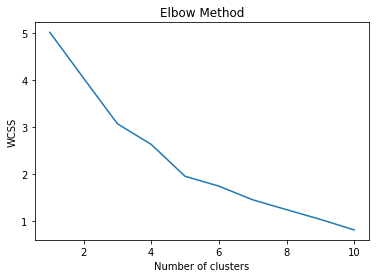

In [116]:
#We will use the elbow method to find the optimal number of clusters
york_grouped_clustering = york_grouped.drop('Neighborhoods', 1)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(york_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [117]:
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(york_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 5, 4])

In [118]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df1 = neighYork.rename({'Neighborhood': 'Neighborhoods'}, axis=1)
#york_merged = neighYork
york_merged = pd.merge(df1, neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods', how='right')
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#york_merged = york_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')

york_merged

,Postal Code,Borough,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3,Food & Drink Shop,Park,Women's Store,Diner,Coffee Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Intersection
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Women's Store,Vietnamese Restaurant,Boutique,Coffee Shop
3,M3B,North York,Don Mills,43.745906,-79.352188,2,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Caribbean Restaurant
4,M3C,North York,Don Mills,43.725900,-79.340923,2,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Caribbean Restaurant
5,M6B,North York,Glencairn,43.709577,-79.445073,2,Park,Pub,Pizza Place,Japanese Restaurant,Fried Chicken Joint
6,M2H,North York,Hillcrest Village,43.803762,-79.363452,2,Dog Run,Athletics & Sports,Mediterranean Restaurant,Pool,Golf Course
7,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,2,Coffee Shop,Bank,Mobile Phone Shop,Sandwich Place,Gas Station
8,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Juice Bar,Japanese Restaurant
9,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,2,Furniture / Home Store,Miscellaneous Shop,Caribbean Restaurant,Metro Station,Massage Studio


In [146]:
address = 'North York, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York, Canada are {}, {}.'.format(latitude, longitude))

#Finally, let's visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(york_merged['Latitude'], york_merged['Longitude'], york_merged['Neighborhoods'], york_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of North York, Canada are 43.7543263, -79.44911696639593.
